In [1]:
import os 
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers

In [4]:
file = '../../data/data_model/data_sound_mfcc2.pickle'
file = '../../data/data_model/data_sound_event_mel_norm_augmented_2.pickle'

In [5]:
import pickle 

with open(file, 'rb') as handle:
    data = pickle.load(handle)


In [6]:
X = data['feature']
label = data['label']
X = np.reshape(X, (*X.shape,1))
#index_data = np.where(label.label != 3)[0]
#label = label.iloc[index_data].reset_index(drop=True)
#X = X[index_data,:]

In [7]:
label['Subject_ID'] = label['file'].str.split('_').str[0]
label['Location'] = label['file'].str.split('_').str[2]
label['Device'] = label['file'].str.split('_').str[4]

In [9]:
import sklearn

SubjectID = sklearn.utils.shuffle(label.Subject_ID.unique())
SubjectID
SubjectID_train = SubjectID[:100]
SubjectID_test = SubjectID[100:]

In [10]:
label['train_test_split'] = np.where(label['Subject_ID'].isin(SubjectID_train),'train','test')

In [11]:
index_train= np.where(label.train_test_split == 'train')[0]
index_test = np.where(label.train_test_split == 'test')[0]

In [17]:
label

,start,end,label,duration,file,Subject_ID,Location,Device,train_test_split
0,2.207,2.407,1,0.200,122_2b1_Tc_mc_LittC2SE,122,Tc,LittC2SE,train
1,5.693,5.864,1,0.171,122_2b1_Tc_mc_LittC2SE,122,Tc,LittC2SE,train
2,5.907,6.579,1,0.672,122_2b1_Tc_mc_LittC2SE,122,Tc,LittC2SE,train
3,9.093,9.321,1,0.228,122_2b1_Tc_mc_LittC2SE,122,Tc,LittC2SE,train
4,12.807,13.521,1,0.714,122_2b1_Tc_mc_LittC2SE,122,Tc,LittC2SE,train
...,...,...,...,...,...,...,...,...,...
37027,13.341,13.376,2,0.035,154_3b3_Ar_mc_AKGC417L,154,Ar,AKGC417L,train
37028,14.820,14.845,2,0.025,154_3b3_Ar_mc_AKGC417L,154,Ar,AKGC417L,train
37029,15.905,15.943,2,0.038,154_3b3_Ar_mc_AKGC417L,154,Ar,AKGC417L,train
37030,16.226,16.251,2,0.025,154_3b3_Ar_mc_AKGC417L,154,Ar,AKGC417L,train


In [15]:
X_train = X[index_train,:]
X_test = X[index_test,:]
y_train = label.loc[label['train_test_split'] == 'train','label'].to_numpy()
y_test = label.loc[label['train_test_split'] == 'test','label'].to_numpy()

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

IndexError: index 37028 is out of bounds for axis 0 with size 37028

In [251]:
6812/(30220+6812)

0.18394901706632102

In [229]:
label[label.train_test_split=='train'].label.value_counts()

0    19041
2     7754
1     3425
Name: label, dtype: int64

<h1> Deep Learning Model<h1>

In [230]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)    
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)

n_class = len(np.unique(y_train))
print('number of class identified: {}'.format(n_class))

{0: 0.5290338392591426, 1: 2.941119221411192, 2: 1.299114435560141}
number of class identified: 3


In [245]:

model = models.Sequential()

model.add(layers.Conv2D(64, [11,11], strides = [2,2],input_shape = X_train.shape[1:],activation='relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(128, [3,3],activation='relu'))
model.add(layers.Conv2D(128, [3,3],activation='relu'))
model.add(layers.MaxPool2D())


model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(n_class, activation = 'softmax'))
model.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_322 (Conv2D)         (None, 25, 145, 64)       7808      
                                                                 
 max_pooling2d_223 (MaxPooli  (None, 12, 72, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_323 (Conv2D)         (None, 10, 70, 128)       73856     
                                                                 
 conv2d_324 (Conv2D)         (None, 8, 68, 128)        147584    
                                                                 
 max_pooling2d_224 (MaxPooli  (None, 4, 34, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_74 (Flatten)        (None, 17408)           

In [246]:
opt = optimizers.Adam(lr=0.0001)
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = opt,
    metrics=['accuracy'])

history = model.fit(X_train,
            y_train,
            batch_size=16,
            epochs=15,
            class_weight=class_weights,
            validation_data=(X_test, y_test))

/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
1889/1889 [==============================] - 216s 114ms/step - loss: 0.4038 - accuracy: 0.8682 - val_loss: 0.2727 - val_accuracy: 0.9275
Epoch 2/15
1889/1889 [==============================] - 214s 113ms/step - loss: 0.3162 - accuracy: 0.9032 - val_loss: 0.3974 - val_accuracy: 0.8804
Epoch 3/15
1889/1889 [==============================] - 205s 108ms/step - loss: 0.2663 - accuracy: 0.9177 - val_loss: 0.5586 - val_accuracy: 0.7632
Epoch 4/15
1889/1889 [==============================] - 200s 106ms/step - loss: 0.2292 - accuracy: 0.9269 - val_loss: 0.4284 - val_accuracy: 0.8376
Epoch 5/15
1889/1889 [==============================] - 197s 104ms/step - loss: 0.1972 - accuracy: 0.9355 - val_loss: 0.3249 - val_accuracy: 0.8953
Epoch 6/15
1889/1889 [==============================] - 201s 106ms/step - loss: 0.1739 - accuracy: 0.9434 - val_loss: 0.6492 - val_accuracy: 0.7409
Epoch 7/15
1889/1889 [==============================] - 196s 104ms/step - loss: 0.1535 - accuracy: 0.9509 - val_

Text(0.5, 1.0, 'Loss')

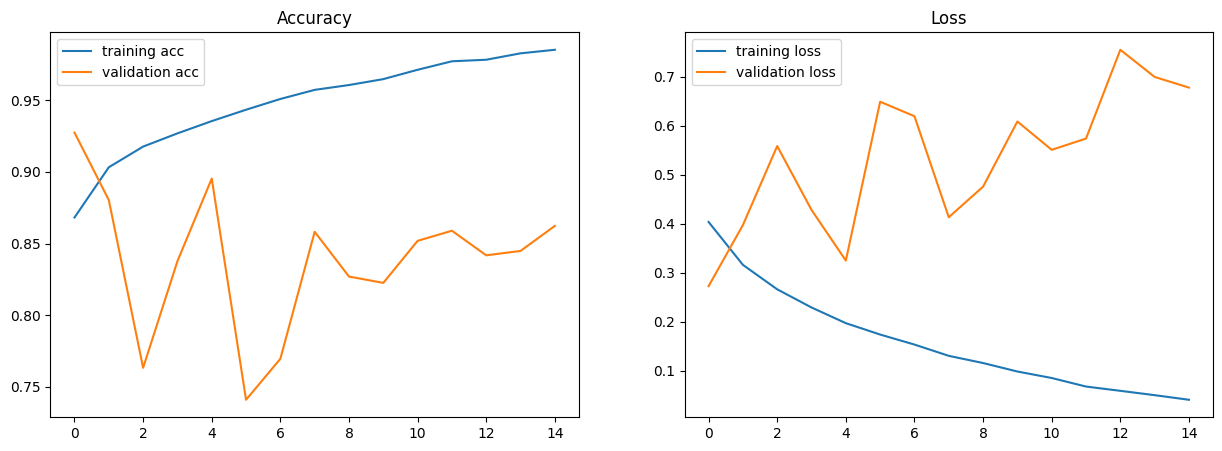

In [247]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [248]:
print("Evaluate model on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate model on test data
213/213 [==============================] - 10s 46ms/step - loss: 0.6780 - accuracy: 0.8623
test loss, test acc: [0.6780217885971069, 0.8623018264770508]


In [249]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict,axis=1)
confusion_matrix(y_test, y_predict)

213/213 [==============================] - 10s 46ms/step


array([[4115,  449,  261],
       [  89,  317,   10],
       [  85,   44, 1442]])

In [250]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      4825
           1       0.39      0.76      0.52       416
           2       0.84      0.92      0.88      1571

    accuracy                           0.86      6812
   macro avg       0.73      0.84      0.77      6812
weighted avg       0.90      0.86      0.87      6812



Text(0.5, 1.0, 'label:1, predicted = 1')

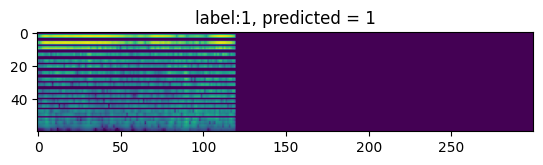

In [255]:
i = 
plt.imshow(X_test[i,:,:,0])
plt.
plt.title("label:{}, predicted = {}".format(y_test[i],y_predict[i]))

In [277]:
X_test.shape

(6812, 60, 300, 1)

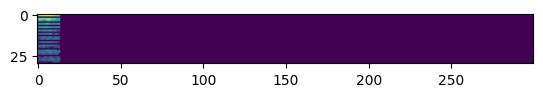

In [281]:
plt.imshow(X_test[2,1::2,:,0])

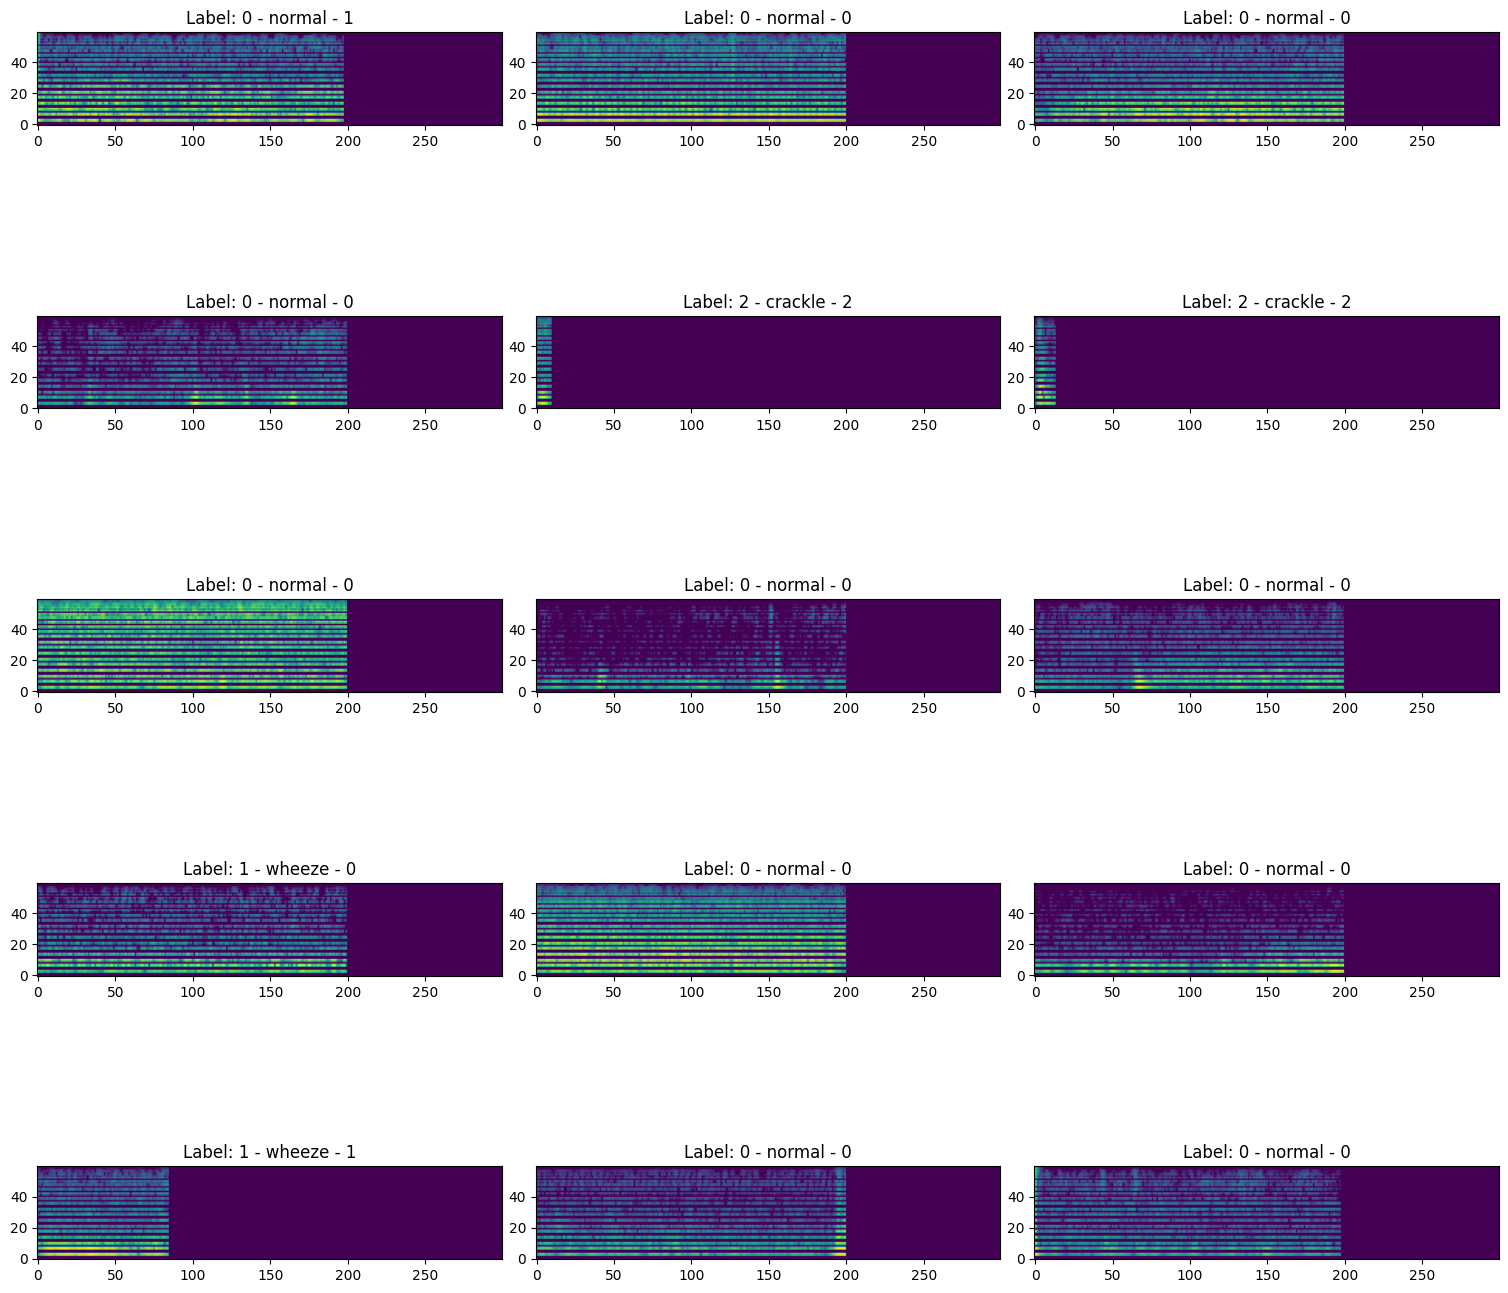

In [272]:
classes = {0:'normal',1:'wheeze',2:'crackle'}
f,axes = plt.subplots(5,3,figsize=(15,15))
axes = axes.flatten()
for ax in axes:
    index_classes_sample = np.random.choice(X_test.shape[0])
    label_ = y_test[index_classes_sample]
    ax.imshow(X_test[index_classes_sample,:,:])
    ax.invert_yaxis()
    ax.set_title('Label: {} - {} - {}'.format(label_, classes[label_], y_predict[index_classes_sample]))
f = plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)